In [1]:
import cfinversion
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import IPython.display
from matplotlib_inline.backend_inline import set_matplotlib_formats
from tol_colors import tol_cmap, tol_cset
plt.rcParams['svg.fonttype'] = 'none'
IPython.display.set_matplotlib_formats = set_matplotlib_formats
set_matplotlib_formats('svg')


In [43]:
from cfinversion.continuous import *
def FitMethods(cf, T = 10, precision = 10e-2):
  N = int(2 * T / precision)
  methods = {
            'Bohman A' : BohmanA(N=N,delta=precision),
            'Bohman B' : BohmanB(N=N,delta=precision),
            'Bohman C' : BohmanC(N=N,delta=precision),
            'Bohman D' : BohmanD(N=N,delta=precision), 
            'Bohman E' : BohmanE(N=N,delta=precision, K = 8),
            'Witkovsky GP'  : NaiveGPInverter(N = 10,delta=10/N, num_points=N),
            'Witkovsky FFT' : FFTInverter(N=N, A = -T, B = T)
            }
  
  for method in methods:
    methods[method].fit(cf)
  return methods

In [44]:
from cfinversion.tools import lre
from cfinversion.distributions import *

In [45]:
epsilon = 0.1
x_sym = np.linspace(-2, 2, 1000)
x_pos = np.linspace(0 + epsilon, 1 - epsilon, 1000)
cases = [(Norm(0, 1), x_sym, 'Normal'),
         (Laplace(0, 1), x_sym, 'Laplace'),
         (Uniform(0, 1), x_pos, 'Uniform'),
         (UniformSquared(0, 1), x_pos, 'UniformSquared')]
stat = {}
results_save = {}
N = [int(10**k) for k in np.linspace(1, 3, 5)]
for i in range(4):
  print(f'iterr {i}')
  dist, x, dist_name = cases[i]
  stat[dist_name] = {}
  results_save[dist_name] = {}
  for n in N:
    results = FitMethods(dist.chr, n)
    results_save[dist_name][n] = results
    stat[dist_name][n] = {}
    #stat[dist_name]['lre_errors_pdf'] = []
    #stat[dist_name]['lre_errors_cdf'] = []
    stat[dist_name][n]['sup_error_pdf'] = {}
    stat[dist_name][n]['sup_error_cdf'] = {} 
    stat[dist_name][n]['mae_pdf'] = {}
    stat[dist_name][n]['mae_cdf'] = {}
    stat[dist_name][n]['mse_pdf'] = {}
    stat[dist_name][n]['mse_cdf'] = {}
    stat[dist_name][n]['mae_std_pdf'] = {}
    stat[dist_name][n]['mae_std_cdf'] = {}
    stat[dist_name][n]['mse_std_pdf'] = {}
    stat[dist_name][n]['mse_std_cdf'] = {}
    for m, estim in results.items():
      errors_cdf = dist.cdf(x) - np.real(estim.cdf(x))
      errors_pdf = dist.pdf(x) - np.real(estim.pdf(x))
      # stat[dist_name]['lre_errors_pdf'] += [lre(dist.pdf(x), estim.pdf(x))]
      # stat[dist_name]['lre_errors_cdf'] += [lre(dist.cdf(x), estim.cdf(x))]
      stat[dist_name][n]['sup_error_pdf'][m] = np.max(np.abs(errors_pdf))
      stat[dist_name][n]['sup_error_cdf'][m] = np.max(np.abs(errors_cdf))
      stat[dist_name][n]['mae_pdf'][m] = np.mean(np.abs(errors_pdf))
      stat[dist_name][n]['mae_cdf'][m] = np.mean(np.abs(errors_cdf))
      stat[dist_name][n]['mse_pdf'][m] = np.mean(np.abs(errors_pdf**2))
      stat[dist_name][n]['mse_cdf'][m] = np.mean(np.abs(errors_cdf**2))
      stat[dist_name][n]['mae_std_pdf'][m] = np.std(np.abs(errors_pdf))
      stat[dist_name][n]['mae_std_cdf'][m] = np.std(np.abs(errors_cdf))
      stat[dist_name][n]['mse_std_pdf'][m] = np.std(errors_pdf**2)
      stat[dist_name][n]['mse_std_cdf'][m] = np.std(errors_cdf**2)

iterr 0
iterr 1
iterr 2
iterr 3


In [46]:
methods = list(results.keys())

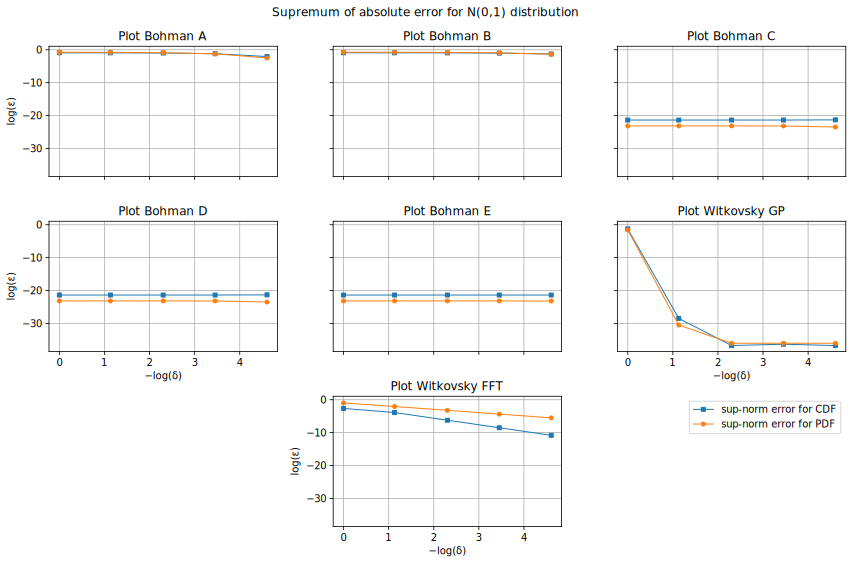

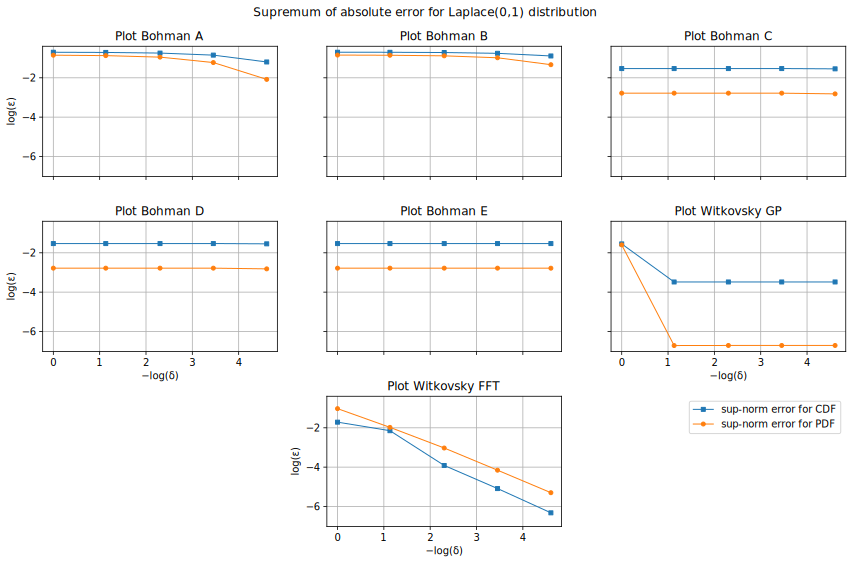

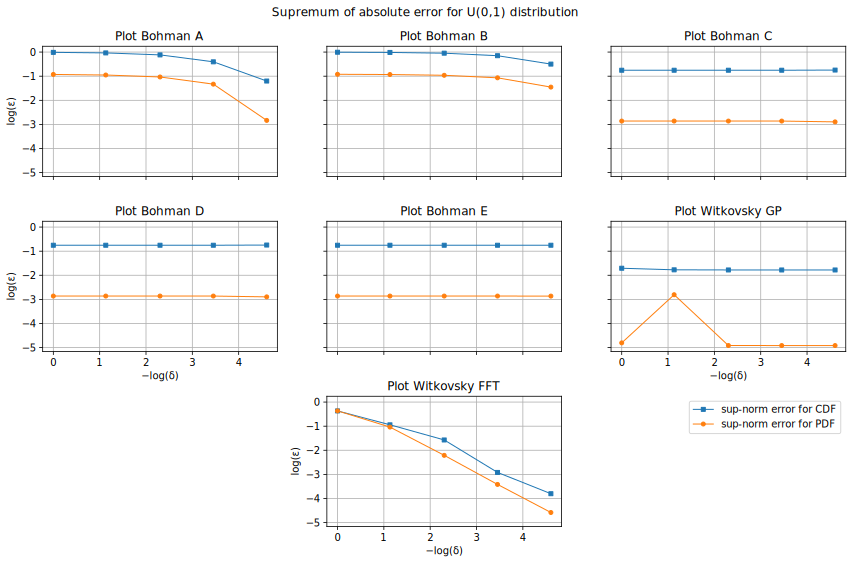

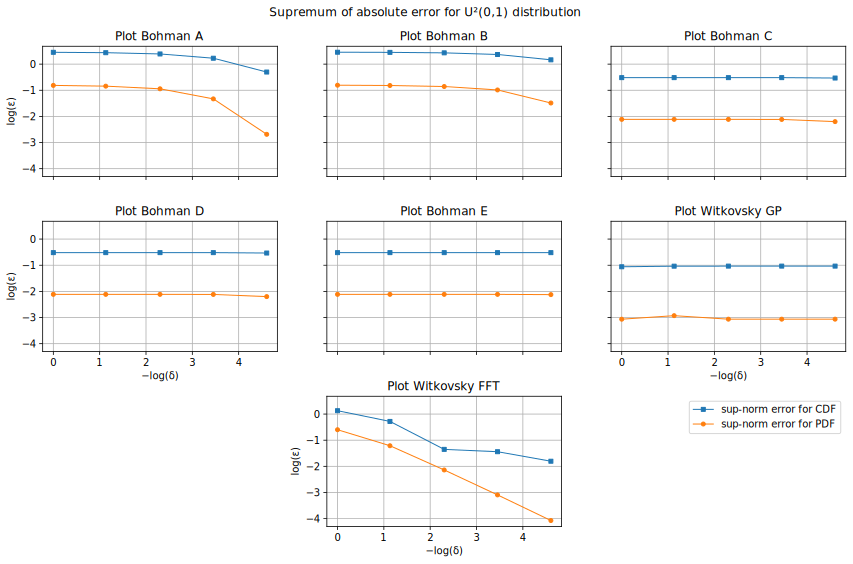

In [47]:
import matplotlib.pyplot as plt
import numpy as np

for name, dist in [('N(0,1)', 'Normal'), ('Laplace(0,1)', 'Laplace'), ('U(0,1)', 'Uniform'), ('U²(0,1)', 'UniformSquared')]:
  # Create a 3x3 grid of subplots (9 positions, we'll use 7)
  fig, axes = plt.subplots(3, 3, figsize=(12, 8), sharex=True, sharey=True)
  # Flatten the axes array for easier iteration
  axes_flat = axes.flatten()
  # Common x and y tick values
  # xticks = np.arange(0, 11, 2)  # 0-10 in steps of 2
  # yticks = np.arange(-1, 1.1, 0.5)  # -1 to 1 in steps of 0.5
  # Generate and plot data for each of the 7 axes
  for i in range(7):
      ax = axes_flat[i] if i != 6 else axes_flat[i+1]
      # Generate sample data (replace with your actual data)
      err = np.array([stat[dist][n]['sup_error_pdf'][methods[i]] for n in N])
      err2 = np.array([stat[dist][n]['sup_error_cdf'][methods[i]] for n in N])
      ax.plot(-np.log(10 / np.array(N)), np.log(err), marker='s', linewidth=1, markersize=4, label = 'sup-norm error for CDF')
      ax.plot(-np.log(10 / np.array(N)), np.log(err2), marker='o', linewidth=1, markersize=4, label = 'sup-norm error for PDF')
      #ax.fill_between(np.log(np.array(N)), mae), np.log(mae + std), alpha =0.2)
      ax.set_title(f'Plot {methods[i]}')  
      # Only show labels for bottom row and leftmost column
      if i % 3 == 0:  # Leftmost column
        ax.set_ylabel('$\\log(\\varepsilon)$')
      ax.grid()
  # Turn off unused axes (positions 7 and 8)
  axes_flat[3].set_xlabel('$-\\log(\\delta)$')
  axes_flat[5].set_xlabel('$-\\log(\\delta)$')
  axes_flat[7].set_xlabel('$-\\log(\\delta)$')
  axes_flat[6].axis('off')
  axes_flat[8].axis('off')
  axes_flat[8].plot([],[], marker='s', linewidth=1, markersize=4, label = 'sup-norm error for CDF')
  axes_flat[8].plot([],[], marker='o', linewidth=1, markersize=4, label = 'sup-norm error for PDF')
  axes_flat[8].legend(alignment='right')
  # Adjust layout to prevent overlapping
  axes_flat[3].xaxis.set_tick_params(which='both', labelbottom=True)
  axes_flat[5].xaxis.set_tick_params(which='both', labelbottom=True)
  axes_flat[7].yaxis.set_tick_params(which='both', labelbottom=True)
  fig.suptitle(f'Supremum of absolute error for {name} distribution')
  fig.tight_layout()
  
  fig.show()
  fig.savefig(f'{dist}_error_convergence.svg')